# Daily News Prediction Models

Description:

There are two channels of data provided in this dataset:

News data: I crawled historical news headlines from Reddit WorldNews Channel (/r/worldnews). They are ranked by reddit users' votes, and only the top 25 headlines are considered for a single date. (Range: 2008-06-08 to 2016-07-01)
Stock data: Dow Jones Industrial Average (DJIA) is used to "prove the concept". (Range: 2008-08-08 to 2016-07-01)

1" when DJIA Adj Close value rised or stayed as the same;

"0" when DJIA Adj Close value decreased.

For task evaluation, please use data from 2008-08-08 to 2014-12-31 as Training Set, and Test Set is then the following two years data (from 2015-01-02 to 2016-07-01). This is roughly a 80%/20% split.

I am using AUC as the evaluation metric.

In [1]:
import pandas as pd
import numpy as np
import plotly                                   # just to print version and init notebook
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import plotly.tools as tls
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
plotly.offline.init_notebook_mode()
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import requests
from io import BytesIO

# importing file
data = pd.read_csv('C:\\Users\\Manoj\\Google Drive\\Study Materials\\Spring 17 Courses\\Learning_Python_OOP\\Daily_News\\Combined_News_DJIA.csv')

## Data Exploration

We are using bag of words concept. The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.

Using WordCloud package, to visualise which are most common occuring words when market goes up or down.

In [3]:
# creating string market_up_text and market_down_text which combines all text of highlines.

market_up = []
for row in range(0,len(data.index)):
    if data['Label'][row] == 1:
        market_up.append(' '.join(str(x) for x in data.iloc[row,2:27]))
        
market_down = []
for row in range(0,len(data.index)):
    if data['Label'][row] == 0:
        market_down.append(' '.join(str(x) for x in data.iloc[row,2:27]))
        
market_up_text = ''.join(market_up)
market_down_text = ''.join(market_up)

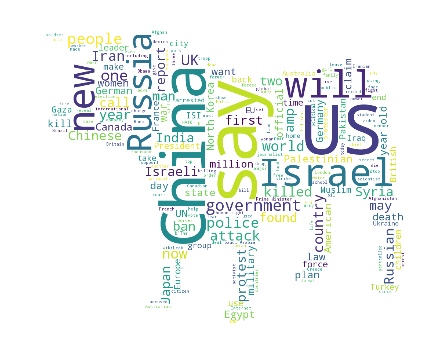

In [49]:
# read the mask image
#bull_mask = np.array(Image.open('C://Users//Manoj//Downloads//bull1.jpg'))
#bear_mask = np.array(Image.open('C://Users//Manoj//Downloads//bear1.jpg'))

response_bull = requests.get('http://www.spstencils.com/wp-content/uploads/2014/08/bull.jpg')
bull_mask = np.array(Image.open(BytesIO(response_bull.content)))

response_bear = requests.get('http://www.spstencils.com/wp-content/uploads/2014/08/Bear.jpg')
bear_mask = np.array(Image.open(BytesIO(response_bear.content)))

# Setting stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")

#using bull mask to visualise words when market is up
wc_up = WordCloud(background_color="white",mask=bull_mask,
               stopwords=stopwords)

#using bear mask to visualise words when market is down
wc_down = WordCloud(background_color="white",mask=bear_mask,
               stopwords=stopwords)

# generate word clouds
wc_up.generate(market_up_text)
wc_down.generate(market_down_text)

# store word clouds to local file
wc_up.to_file('C://Users//Manoj//Downloads//bull2.jpg')
wc_down.to_file('C://Users//Manoj//Downloads//bear2.jpg')

# show
plt.imshow(wc_up, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.show()

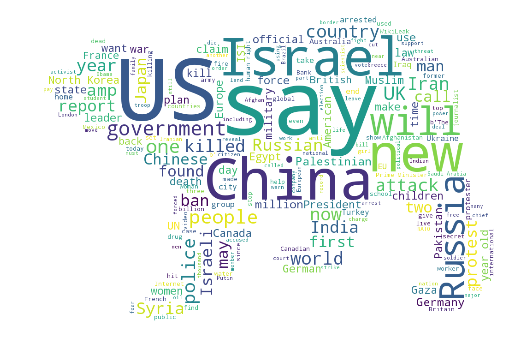

In [50]:
plt.imshow(wc_down, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(10,10))
plt.show()

## Data and Model Preparation

I will be running following classification Models:
1. Logistic Regression
2. Decision Tree Model
3. Random Forest Model

I am starting with NGRAM = 1, i.e. I will be split sentenece in single words, But sometimes combinations of word makes more sense and can have more predictive value. 

    eg. 'US and Japan Signed Trade deal'
            If Ngram =1, then above statement will be split as 'US', 'and', 'Japan', 'Signed', 'Trade', 'deal'
            If Ngram =1, then above statement will be split as 'US and', 'Japan Signed', 'Trade deal'

I am splitting training and test dataset set 80%/20% split

In [8]:
train = data[data['Date'] <= '2015-01-30']
test = data[data['Date'] > '2015-01-30']

Model_Metric dataframe is used to store performance metrics of all models and update_model_metrics is function to update it.

In [6]:
Model_Metrics = pd.DataFrame(data=None,columns =['Accuracy','Precision','Recall','F-1 score','AUC'])
def update_model_metrics(y_true,y_pred, model_name):
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall = sklearn.metrics.recall_score(y_true, y_pred)
    f1_score = sklearn.metrics.recall_score(y_true, y_pred)
    auc = sklearn.metrics.roc_auc_score(y_true, y_pred)
    metrics =[accuracy,precision,recall,f1_score,auc]
    Model_Metrics.loc[model_name] = metrics    

combining all headlines of training and testinf data in single lists

In [9]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))

testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))

Creating bag of words using CountVectorizer

In [10]:
vectorizer1 = CountVectorizer()
train1 = vectorizer1.fit_transform(trainheadlines)
test1 = vectorizer1.transform(testheadlines)

### Logistic Regression Model with Ngram =1

In [12]:
logisticmodel1 = LogisticRegression()
logisticmodel1 = logisticmodel1.fit(train1, train["Label"])
logistic_predictions1 = logisticmodel1.predict(test1)
update_model_metrics(test['Label'].values,logistic_predictions1,'Logistic Regression(NGram =1)')
Model_Metrics

Accuracy  Precision    Recall  F-1 score  \
Logistic Regression(NGram =1)  0.444134   0.460396  0.508197   0.508197   

                                   AUC  
Logistic Regression(NGram =1)  0.44267

In [13]:
pd.crosstab(test["Label"], logistic_predictions1, rownames=["Actual"], colnames=["Predicted"])

Predicted   0    1
Actual            
0          66  109
1          90   93

Plotting ROC Curve

In [14]:
fpr_l, tpr_l, thresholds = sklearn.metrics.roc_curve(test['Label'].values,logistic_predictions1)

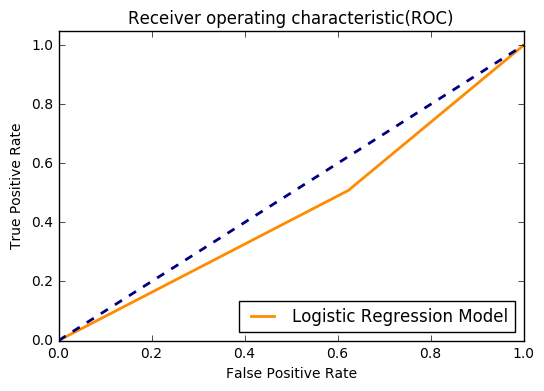

In [15]:
plt.figure()
lw = 2
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw, label='Logistic Regression Model')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC)')
plt.legend(loc="lower right")
plt.show()

### Decision Tree Model

In [16]:
decisiontreemodel1 = DecisionTreeClassifier()
decisiontreemodel1 = decisiontreemodel1.fit(train1, train["Label"])
decisiontree_predictions1 = decisiontreemodel1.predict(test1)
update_model_metrics(test['Label'].values,decisiontree_predictions1,'Decision Tree Model(NGram =1)')
Model_Metrics

Accuracy  Precision    Recall  F-1 score  \
Logistic Regression(NGram =1)  0.444134   0.460396  0.508197   0.508197   
Decision Tree Model(NGram =1)  0.530726   0.536585  0.601093   0.601093   

                                    AUC  
Logistic Regression(NGram =1)  0.442670  
Decision Tree Model(NGram =1)  0.529118

In [17]:
pd.crosstab(test["Label"], decisiontree_predictions1, rownames=["Actual"], colnames=["Predicted"])

Predicted   0    1
Actual            
0          80   95
1          73  110

In [18]:
fpr_d, tpr_d, thresholds = sklearn.metrics.roc_curve(test['Label'].values,decisiontree_predictions1)

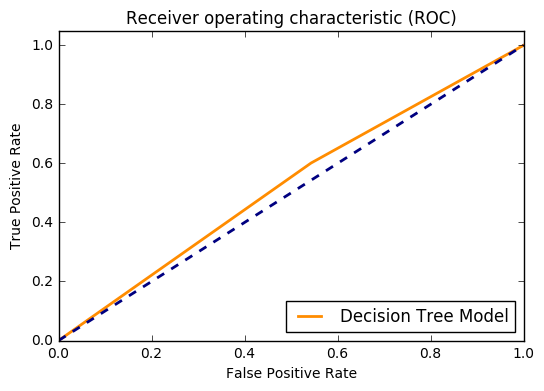

In [19]:
plt.figure()
lw = 2
plt.plot(fpr_d, tpr_d, color='darkorange',
         lw=lw, label='Decision Tree Model')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Random Forest Model

In [20]:
randomforestmodel1 = RandomForestClassifier()
randomforestmodel1 = randomforestmodel1.fit(train1, train["Label"])
randomforest_predictions1 = randomforestmodel1.predict(test1)
update_model_metrics(test['Label'].values,randomforest_predictions1,'Random Forest Model(NGram =1)')
Model_Metrics

Accuracy  Precision    Recall  F-1 score  \
Logistic Regression(NGram =1)  0.444134   0.460396  0.508197   0.508197   
Decision Tree Model(NGram =1)  0.530726   0.536585  0.601093   0.601093   
Random Forest Model(NGram =1)  0.536313   0.550296  0.508197   0.508197   

                                    AUC  
Logistic Regression(NGram =1)  0.442670  
Decision Tree Model(NGram =1)  0.529118  
Random Forest Model(NGram =1)  0.536956

In [21]:
pd.crosstab(test["Label"], randomforest_predictions1, rownames=["Actual"], colnames=["Predicted"])

Predicted   0   1
Actual           
0          99  76
1          90  93

In [22]:
fpr_f, tpr_f, thresholds = sklearn.metrics.roc_curve(test['Label'].values,randomforest_predictions1)

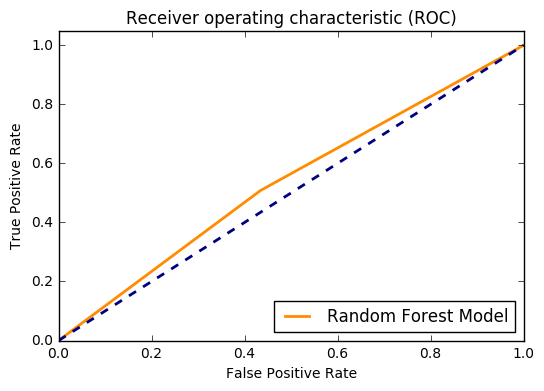

In [23]:
plt.figure()
lw = 2
plt.plot(fpr_f, tpr_f, color='darkorange',
         lw=lw, label='Random Forest Model')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

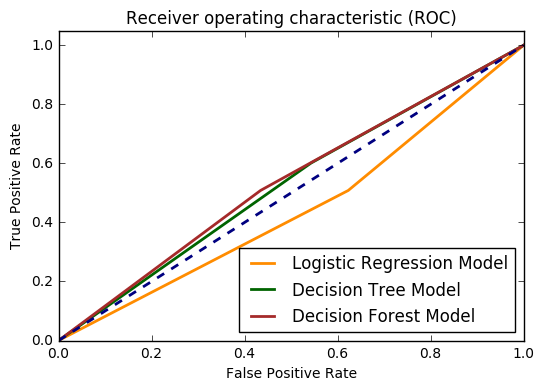

In [24]:
plt.figure()
lw = 2
plt.plot(fpr_l, tpr_l, color='darkorange',
         lw=lw, label='Logistic Regression Model')
plt.plot(fpr_d, tpr_d, color='darkgreen',
         lw=lw, label='Decision Tree Model')
plt.plot(fpr_f, tpr_f, color='brown',
         lw=lw, label='Decision Forest Model')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Prediction Models for Ngram_Range = (2,2)

In [25]:
vectorizer2 = CountVectorizer(ngram_range=(2,2))
train2 = vectorizer2.fit_transform(trainheadlines)
test2 = vectorizer2.transform(testheadlines)

In [26]:
logisticmodel2 = LogisticRegression()
logisticmodel2 = logisticmodel2.fit(train2, train["Label"])
logistic_predictions2 = logisticmodel2.predict(test2)
update_model_metrics(test['Label'].values,logistic_predictions2,'Logistic Regression Model(NGram =2)')

In [27]:
decisiontreemodel2 = DecisionTreeClassifier()
decisiontreemodel2 = decisiontreemodel2.fit(train2, train["Label"])
decisiontree_predictions2 = decisiontreemodel2.predict(test2)
update_model_metrics(test['Label'].values,decisiontree_predictions2,'Decision Tree Model(NGram =2)')

In [28]:
randomforestmodel2 = RandomForestClassifier()
randomforestmodel2 = randomforestmodel2.fit(train2, train["Label"])
randomforest_predictions2 = randomforestmodel2.predict(test2)
update_model_metrics(test['Label'].values,randomforest_predictions2,'Random Forest Model(NGram =2)')
Model_Metrics

Accuracy  Precision    Recall  F-1 score  \
Logistic Regression(NGram =1)        0.444134   0.460396  0.508197   0.508197   
Decision Tree Model(NGram =1)        0.530726   0.536585  0.601093   0.601093   
Random Forest Model(NGram =1)        0.536313   0.550296  0.508197   0.508197   
Logistic Regression Model(NGram =2)  0.567039   0.556452  0.754098   0.754098   
Decision Tree Model(NGram =2)        0.494413   0.504950  0.557377   0.557377   
Random Forest Model(NGram =2)        0.527933   0.528926  0.699454   0.699454   

                                          AUC  
Logistic Regression(NGram =1)        0.442670  
Decision Tree Model(NGram =1)        0.529118  
Random Forest Model(NGram =1)        0.536956  
Logistic Regression Model(NGram =2)  0.562763  
Decision Tree Model(NGram =2)        0.492974  
Random Forest Model(NGram =2)        0.524012

In [29]:
fpr_l2, tpr_l2, thresholds = sklearn.metrics.roc_curve(test['Label'].values,logistic_predictions2)
fpr_d2, tpr_d2, thresholds = sklearn.metrics.roc_curve(test['Label'].values,decisiontree_predictions2)
fpr_f2, tpr_f2, thresholds = sklearn.metrics.roc_curve(test['Label'].values,randomforest_predictions2)

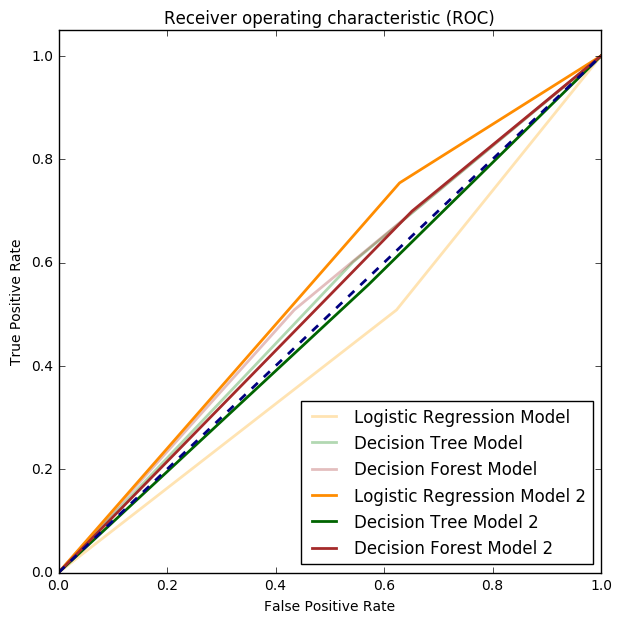

In [30]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr_l, tpr_l, color='orange', alpha = 0.3,
         lw=lw, label='Logistic Regression Model')
plt.plot(fpr_d, tpr_d, color='green',alpha = 0.3,
         lw=lw, label='Decision Tree Model')
plt.plot(fpr_f, tpr_f, color='brown',alpha = 0.3,
         lw=lw, label='Decision Forest Model')
plt.plot(fpr_l2, tpr_l2, color='darkorange',
         lw=lw, label='Logistic Regression Model 2')
plt.plot(fpr_d2, tpr_d2, color='darkgreen',
         lw=lw, label='Decision Tree Model 2')
plt.plot(fpr_f2, tpr_f2, color='brown',
         lw=lw, label='Decision Forest Model 2')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### Prediction Models for Ngram_Range = (3,3)

In [32]:
vectorizer3 = CountVectorizer(ngram_range=(3,3))
train3 = vectorizer3.fit_transform(trainheadlines)
test3 = vectorizer3.transform(testheadlines)

In [33]:
logisticmodel3 = LogisticRegression()
logisticmodel3 = logisticmodel3.fit(train3, train["Label"])
logistic_predictions3 = logisticmodel3.predict(test3)
update_model_metrics(test['Label'].values,logistic_predictions3,'Logistic Regression Model(NGram =3)')

In [34]:
decisiontreemodel3 = DecisionTreeClassifier()
decisiontreemodel3 = decisiontreemodel3.fit(train3, train["Label"])
decisiontree_predictions3 = decisiontreemodel3.predict(test3)
update_model_metrics(test['Label'].values,decisiontree_predictions3,'Decision Tree Model(NGram =3)')

In [36]:
randomforestmodel3 = RandomForestClassifier()
randomforestmodel3 = randomforestmodel3.fit(train3, train["Label"])
randomforest_predictions3 = randomforestmodel3.predict(test3)
update_model_metrics(test['Label'].values,randomforest_predictions3,'Random Forest Model(NGram =3)')
Model_Metrics


Accuracy  Precision    Recall  F-1 score  \
Logistic Regression(NGram =1)        0.444134   0.460396  0.508197   0.508197   
Decision Tree Model(NGram =1)        0.530726   0.536585  0.601093   0.601093   
Random Forest Model(NGram =1)        0.536313   0.550296  0.508197   0.508197   
Logistic Regression Model(NGram =2)  0.567039   0.556452  0.754098   0.754098   
Decision Tree Model(NGram =2)        0.494413   0.504950  0.557377   0.557377   
Random Forest Model(NGram =2)        0.527933   0.528926  0.699454   0.699454   
Logistic Regression Model(NGram =3)  0.519553   0.516517  0.939891   0.939891   
Decision Tree Model(NGram =3)        0.525140   0.527660  0.677596   0.677596   
Random Forest Model(NGram =3)        0.513966   0.513353  0.945355   0.945355   

                                          AUC  
Logistic Regression(NGram =1)        0.442670  
Decision Tree Model(NGram =1)        0.529118  
Random Forest Model(NGram =1)        0.536956  
Logistic Regression Model(NGram =2)  0.562763  
Decision Tree Model(NGram =2)        0.492974  
Random Forest Model(NGram =2)        0.524012  
Logistic Regression Model(NGram =3)  0.509945  
Decision Tree Model(NGram =3)        0.521655  
Random Forest Model(NGram =3)        0.504106

In [37]:
fpr_l3, tpr_l3, thresholds = sklearn.metrics.roc_curve(test['Label'].values,logistic_predictions3)
fpr_d3, tpr_d3, thresholds = sklearn.metrics.roc_curve(test['Label'].values,decisiontree_predictions3)
fpr_f3, tpr_f3, thresholds = sklearn.metrics.roc_curve(test['Label'].values,randomforest_predictions3)

#### Comparision of ROC curve of all graphs

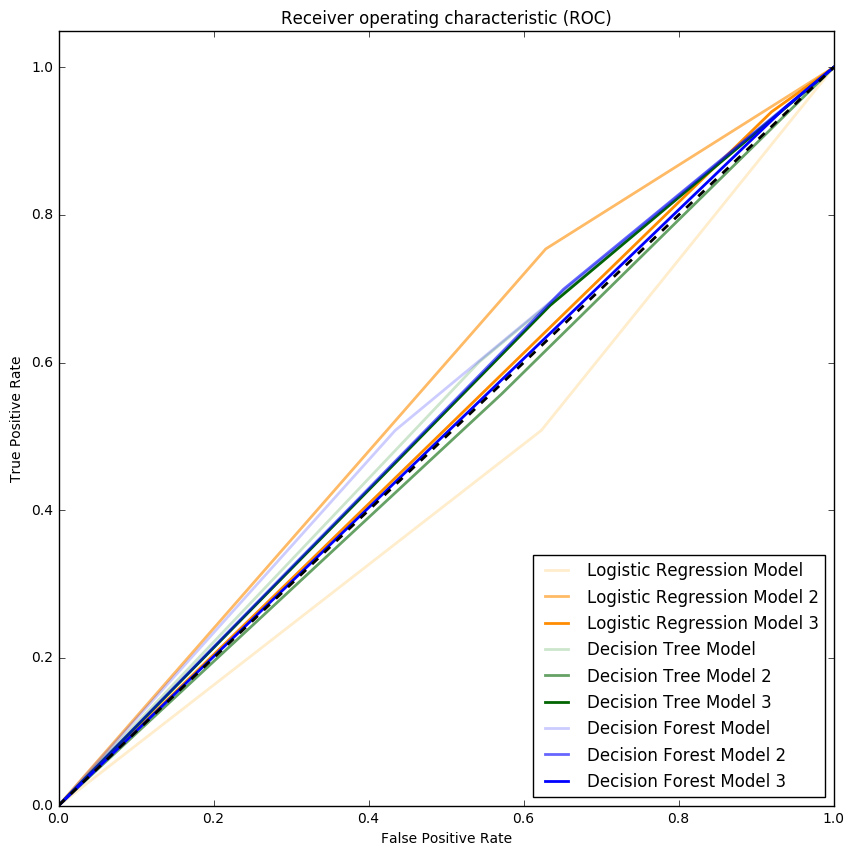

In [38]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr_l, tpr_l, color='orange', alpha = 0.2,
         lw=lw, label='Logistic Regression Model')
plt.plot(fpr_l2, tpr_l2, color='darkorange', alpha = 0.6,
         lw=lw, label='Logistic Regression Model 2')
plt.plot(fpr_l3, tpr_l3, color='darkorange',alpha = 2,
         lw=lw, label='Logistic Regression Model 3')
plt.plot(fpr_d, tpr_d, color='green',alpha = 0.2,
         lw=lw, label='Decision Tree Model')
plt.plot(fpr_d2, tpr_d2, color='darkgreen', alpha = 0.6,
         lw=lw, label='Decision Tree Model 2')
plt.plot(fpr_d3, tpr_d3, color='darkgreen',alpha = 2,
         lw=lw, label='Decision Tree Model 3')
plt.plot(fpr_f, tpr_f, color='blue',alpha = 0.2,
         lw=lw, label='Decision Forest Model')
plt.plot(fpr_f2, tpr_f2, color='blue', alpha = 0.6,
         lw=lw, label='Decision Forest Model 2')
plt.plot(fpr_f3, tpr_f3, color='blue',alpha = 2,
         lw=lw, label='Decision Forest Model 3')
plt.plot([0, 1], [0, 1], color='Black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

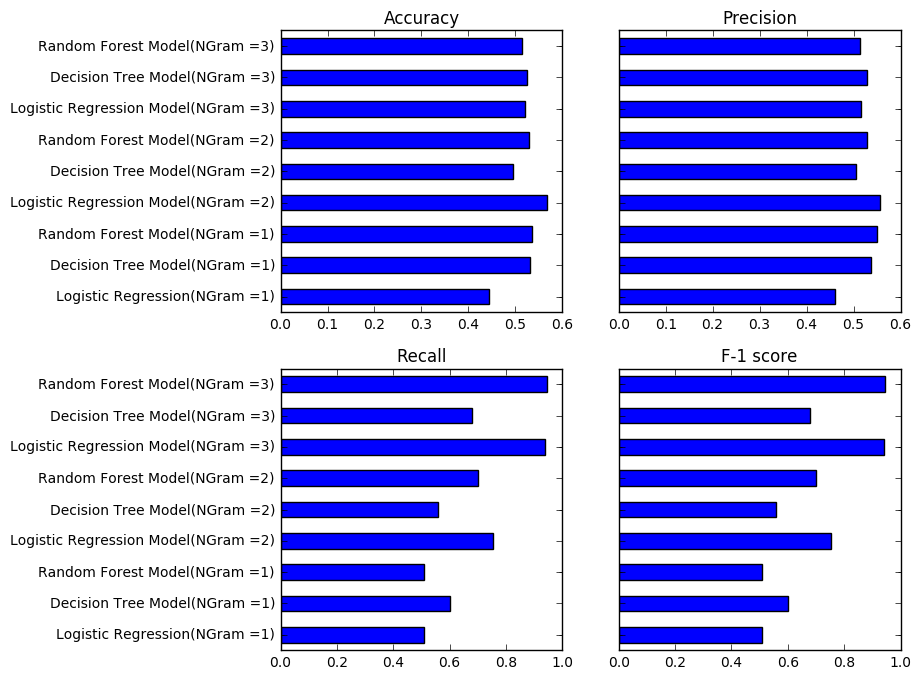

In [39]:
#Model_Metrics['Accuracy'].plot('barh')
#fig,ax = plt.subplots(nrows=2, ncols=2)
fig, axe = plt.subplots(2, 2, sharey=True,figsize=(8,8))
#ax = axs[0, 0]
#ax.plot(Model_Metrics.index, Model_Metrics)
#ax0, ax1, ax2, ax3 = ax.flatten()
Model_Metrics.plot(ax=axe[0, 0],kind='barh',y='Accuracy',legend=False, title ='Accuracy')
Model_Metrics.plot(ax=axe[0, 1],kind='barh',y='Precision',legend=False,title ='Precision')
Model_Metrics.plot(ax=axe[1, 0],kind='barh',y='Recall',legend=False,title ='Recall')
Model_Metrics.plot(ax=axe[1, 1],kind='barh',y='F-1 score',legend=False,title ='F-1 score')
#Model_Metrics.plot.bar(ax=ax, y='Accuracy', legend=False, color="orange")

#ax0.plot(Model_Metrics['Accuracy'])
plt.show()

## Best Predictors

Single words with highest weightage

In [40]:
words = vectorizer1.get_feature_names()
coeffs = logisticmodel1.coef_.tolist()[0]
coeffdf = pd.DataFrame({'Word' : words, 
                        'Coefficient' : coeffs})
coeffdf = coeffdf.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
coeffdf.head(10)

Coefficient      Word
19523     0.460500   nigeria
29437     0.448185        tv
25390     0.441903      self
16081     0.416451     korea
5130      0.414926  canadian
20243     0.411657  olympics
31309     0.392507     woman
28617     0.390362     three
26461     0.389835        so
6194      0.380812     coast

Single words with lowest weightage

In [43]:
coeffdf.tail(10)

Coefficient       Word
8525     -0.448525        did
25564    -0.448576        sex
7795     -0.449434         de
7177     -0.455212    country
3669     -0.464053      begin
17040    -0.471817        low
27443    -0.477251   students
12883    -0.479316    hacking
24882    -0.580911  sanctions
24667    -0.617854        run

Combination of two words with highest weightage

In [44]:
words2 = vectorizer2.get_feature_names()
coeffs2 = logisticmodel2.coef_.tolist()[0]
d = dict(Word=words2, Coefficient =coeffs2 )
coeffdf2 = pd.DataFrame.from_dict(d, orient='index')
#print(len(words),len(coeffs))
#coeffdf = pd.DataFrame({'Word' : words,'Coefficient' : coeffs})
coeffdf2 = coeffdf2.T.dropna(axis=0, how='any')
coeffdf2 = coeffdf2.sort_values(['Coefficient', 'Word'], ascending=[0, 1],na_position ='last')


Combination of two words with Lowest weightage

In [45]:
coeffdf2.tail()

Coefficient         Word
32006    -0.219035   around the
330361   -0.220506      to kill
362453   -0.227852    with iran
344095   -0.228786        up in
318649   -0.327816  the country